In [3]:
%env CUDA_VISIBLE_DEVICES=9
from util import *
from problems import *
from catformer import CatFormer, Transformer
import optax

env: CUDA_VISIBLE_DEVICES=9


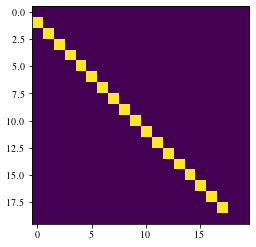

In [11]:
rng = RNG(0)
vocab_size = 10
seq_len = 20
alpha = 0.1

# Markov chain
dag = jnp.arange(seq_len - 1) - 1

# # Random DAG
# dag = rng.randint((seq_len - 1,), minval=-1, maxval=jnp.arange(seq_len - 1))

# # ICL
# dag = jnp.zeros(seq_len - 1, dtype=int) - 1
# dag = dag.at[1::2].set(2 * jnp.arange((seq_len - 1) // 2))

init_model = Transformer(
    seq_len=seq_len,
    vocab_size=vocab_size,
    heads=[1, 1],
    key=rng.next()
)

problem = InContextTree(
    vocab_size=vocab_size,
    dag=dag,
    alpha=alpha,
)
dag = problem.dag

@jit
def criterion(f, y):
    _criterion = lambda f, y: -jnp.log(f) @ y
    for _ in range(y.ndim - 1):
        _criterion = vmap(_criterion)
    return _criterion(f, y).mean()


@jit
def loss_fn(model, batch):
    x, y = batch
    return criterion(model(x), y)


A = jnp.zeros((seq_len, seq_len))
idx = jnp.where(dag >= 0)
A = A.at[idx, dag[idx]].set(1)
plt.imshow(A)


In [12]:
print("Computing Bayes")
testx, testy = vmap(problem.sample)(rng.next(2**16))
logits = vmap(problem.bayes)(testx)
bayes = criterion(logits, testy)

print("Training")
lr = 0.01
wd = 2e-4
steps = 2**12
save_every = steps // 128
batch_size = 2**10
max_size = 2 ** 20
epoch_len = max_size // batch_size
sample_fn = jit(lambda k: vmap(problem.sample)(jr.split(k, epoch_len * batch_size)))

def batch_iterator(key):
    while True:
        key, subkey = jr.split(key)
        batches = sample_fn(subkey)
        for i in range(epoch_len):
            yield tree_map(lambda x: x[batch_size * i : batch_size * (i + 1)], batches)

schedule = optax.cosine_decay_schedule(lr, steps)
opt = optax.adamw(schedule,weight_decay=wd)

@jit
def step_fn(model, batch, opt_state):
    loss, g = jax.value_and_grad(loss_fn)(model, batch)
    updates, opt_state = opt.update(g, opt_state, model)
    model = optax.apply_updates(model, updates)
    return model, opt_state, loss

iterator = batch_iterator(rng.next())
model = init_model
train_loss = []
test_loss = []

opt_state = opt.init(model)
for i in trange(steps):
    if i % save_every == 0:
        test_loss.append(loss_fn(model, (testx, testy)))
    model, opt_state, loss = step_fn(model, next(iterator), opt_state)
    train_loss.append(loss)

Computing Bayes
Training


  0%|          | 0/4096 [00:00<?, ?it/s]

(65536, 20, 30)
(1024, 20, 30)


Text(0.5, 0.98, 'seq len=20')

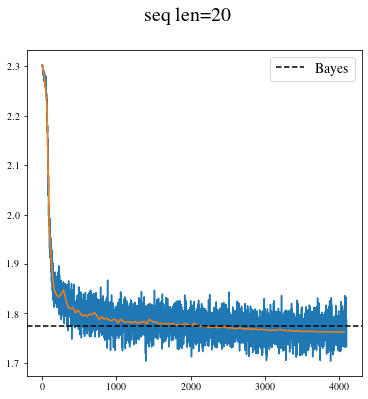

In [13]:
fig = plt.figure(figsize=(6, 6))
plt.plot(train_loss)
plt.plot(jnp.arange(len(test_loss)) * save_every, test_loss)
plt.axhline(bayes, c="k", ls="--", label="Bayes")
plt.legend(fontsize=14)
fig.suptitle(f"seq len={seq_len}", fontsize=20)

In [14]:
def get_attn(x, model, i=0):
    A1 = model.A[i][0]
    x = model.embed(x)
    print(x.shape)
    T = x.shape[-2]
    print(A1.shape)
    attn = jnp.einsum("...ij,jk,...lk -> ...il", x, A1, x)
    attn = jnp.where(jnp.tri(T), attn, -jnp.inf)
    attn = nn.softmax(attn)
    return attn

(1024, 20, 30)
(30, 30)
(20, 20)


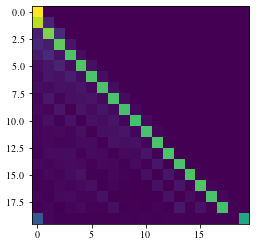

In [15]:
x = next(iterator)[0]
attn_out = get_attn(x, model, i=0)
attn_mean = jnp.mean(attn_out, axis=0)
print(attn_mean.shape)
plt.imshow(attn_mean)
plt.show()

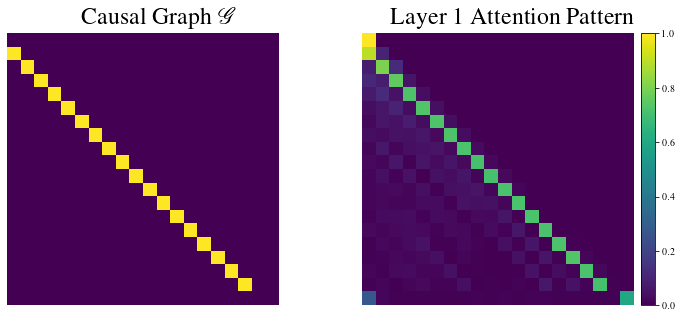

: 

In [16]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.style.use('style.mplstyle')
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

plt.sca(axs[0])
title = plt.title(r"Causal Graph $\mathcal{G}$", fontsize=24, pad = 10)
title.set_position([0.55, 1.05])
plt.imshow(A)
plt.axis("off")

plt.sca(axs[1])
title = plt.title(r"Layer 1 Attention Pattern", fontsize=24, pad = 10)
title.set_position([0.55, 1.05])
plt.imshow(attn_mean)
plt.axis("off")
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(cax=cax)
plt.show()